<a href="https://colab.research.google.com/github/Nathalia-Prada/proyecto-integrador-equipo25/blob/main/Avance5Equipo25%20/Avance5Equipo25_forecast2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Avance 5. Modelo final Series de Tiempo: Forecasting con XGBoost**

3.5 Mejorar significativamente el rendimiento al aprovechar las fortalezas de diferentes modelos y reducir sus debilidades.

3.6 Evaluar la calidad de las predicciones del modelo en datos no vistos.


###**Equipo 25**


### Estudiantes


* A01793899 - Andrés Julián López Hurtado
* A01793999 - Nathalia Milena Prada Hernández
* A01794404 - Victor Alejandro Regueira Romero

Fecha: 27 de octubre de 2024

# Instrucciones
En esta etapa se busca crear una variedad de modelos de ensamble para solucionar el problema planteado. Para ello, deberán tomar en cuenta las siguientes consideraciones:
Incluir la optimización de hiperparámetros para los modelos más relevantes.
Utilizar algoritmos que apliquen tanto estrategias de ensamble homogéneas como heterogéneas.
Para las estrategias de stacking y/o blending, se deberán emplear los modelos individuales de mejor rendimiento obtenidos en la fase anterior.


Una vez que se han generado los modelos de ensamble, sintetizar los resultados en una tabla comparativa en la que se incluyan los modelos individuales de la fase previa.



Los modelos deben ser ordenados por la métrica principal, pero el resumen debe incorporar otras métricas pertinentes.
Se deberán incluir también los tiempos de entrenamiento.
Se elige el modelo final alineado con los objetivos y necesidades del negocio.



Del modelo elegido, generar algunos gráficos significativos con su interpretación. La siguiente lista proporciona ejemplos, pero no es exhaustiva:
- Curva ROC
- Matriz de confusión
- Curva de Precisión-Recall
- Análisis de residuos
- Gráfico de importancia de características
- Tendencia y predicción (para series temporales)
- Diagrama de árbol (para árboles de decisión)

# Importar Drive


In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Librerías


Se inicia importando las librerías y leyendo el dataset.

In [56]:
!pip install optuna

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Rutas de archivos y carga de la base

In [58]:
file_tabla_unida = '/content/drive/MyDrive/TECForza/df_union2.csv'
#file_tabla_unida = '/content/drive/MyDrive/0-Actual/MNA/proyecto_integrador/df_union2.csv'

In [59]:
df_tabla_unida = pd.read_csv(file_tabla_unida)
df_tabla_unida.head()

,name,date,total_distance_used_sum,total_fuel_used_sum,consumption,performance,distance,idlingDuration,idlingPercent,idlingDuration_hours,...,ExcessiveSpeedingCount,ExcessiveSpeedingDistance,HardAccelerationCount,HardAccelerationDistance,HarshBrakingCount,HarshBrakingDistance,HarshCorneringDuration,HarshCorneringCount,HarshCorneringDistance,MaxSpeed
0,986,2024-07-01,115.575006,15.321976,7.543088,0.132572,30.063228,08:12:02,87.0,8.20,...,159.0,50.848373,133.0,0.057267,1.0,0.000096,0.0,43.0,0.006195,83.885109
1,1038,2024-07-01,167.770170,25.096340,6.685045,0.149588,72.647624,06:53:43,62.0,6.90,...,19.0,2.382248,17.0,0.002865,0.0,0.000000,0.0,28.0,0.002594,76.428658
2,502,2024-07-02,1025.262150,68.948892,8.653096,0.067250,912.121800,11:00:31,46.0,11.01,...,105.5,38.452164,48.0,0.020623,0.5,0.000332,0.0,39.5,0.009367,42.874611
3,532,2024-07-02,1103.554896,75.817364,14.555437,0.068703,554.235964,01:34:01,14.0,1.57,...,3.5,0.055369,77.5,0.065764,0.0,0.000000,0.0,18.5,0.007460,38.835701
4,880,2024-07-02,857.491980,64.193796,13.357864,0.074862,429.840038,20:46:51,73.0,20.78,...,402.0,123.554245,59.0,0.020675,0.0,0.000000,0.0,37.0,0.020335,83.885109


# Variables seleccionadas y datasets

In [60]:
df_tabla_unida.columns

Index(['name', 'date', 'total_distance_used_sum', 'total_fuel_used_sum',
       'consumption', 'performance', 'distance', 'idlingDuration',
       'idlingPercent', 'idlingDuration_hours', 'CurrentFuelPrice',
       'IdlingCost', 'SpeedLimit1Count', 'SpeedLimit2Count',
       'SpeedLimit3Count', 'TotalDrivingDuration', 'AverageSpeed',
       'StopUnder10Count', 'StopOver10Count', 'StopOver20Count',
       'StopOver30Count', 'StopOver40Count', 'StopOver50Count',
       'IdlingOver5Count', 'IdlingDuration', 'AfterHoursTripCount',
       'TotalDistance', 'TotalStopsCount', 'SpeedingDuration', 'SpeedingCount',
       'SpeedingDistance', 'ExcessiveSpeedingDuration',
       'ExcessiveSpeedingCount', 'ExcessiveSpeedingDistance',
       'HardAccelerationCount', 'HardAccelerationDistance',
       'HarshBrakingCount', 'HarshBrakingDistance', 'HarshCorneringDuration',
       'HarshCorneringCount', 'HarshCorneringDistance', 'MaxSpeed'],
      dtype='object')

In [61]:
selected_columns = ['date', 'consumption']
df = df_tabla_unida[selected_columns]

Para el análisis de series de tiempo, se necesitan únicamente el consumo y la fecha del viaje, en este caso, las columnas `consumption` y `date`, respectivamente. Se asignará la columna `date` al índice del dataframe; sin embargo, antes debe convertirse de tipo *object* a *datetime* utilizando el método `to_datetime` de la librería Pandas. Finalmente, se muestra el consumo en una frecuencia de acumulado diario.

In [62]:
#convertir a datetime
df['date'] = pd.to_datetime(df['date'])
df_fc = df.set_index('date')

<ipython-input-62-6668be612607>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


In [63]:
#crear acumulado diario
count_date = df_fc.groupby(df_fc.index.date)['consumption'].sum()
fc_clean = pd.DataFrame(count_date)
fc_clean['date'] = pd.to_datetime(fc_clean.index)
fc_clean = fc_clean.set_index('date')

In [64]:
fc_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61 entries, 2024-07-01 to 2024-08-31
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   consumption  61 non-null     float64
dtypes: float64(1)
memory usage: 976.0 bytes


El primer paso en cualquier análisis de series de tiempo es graficar los datos. La visualización permite detectar patrones, lecturas atípicas, variaciones en el tiempo y la relación entre variables.

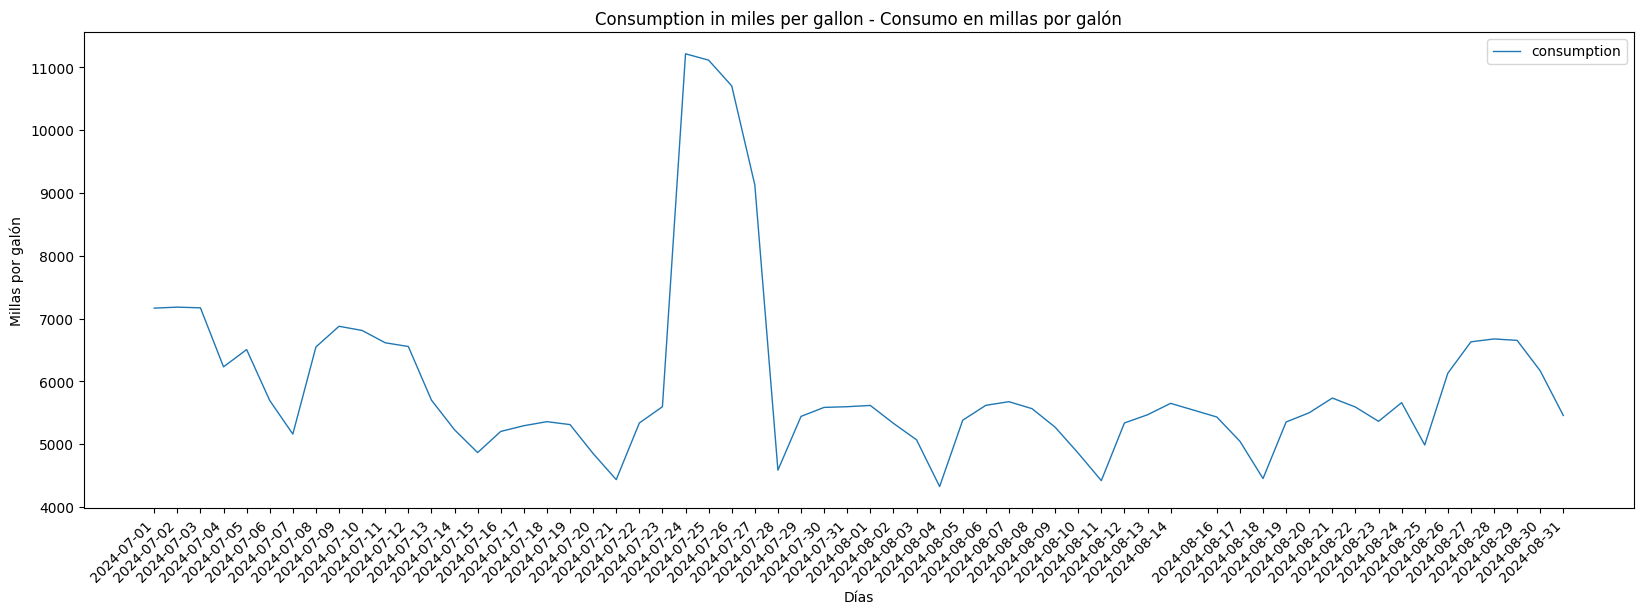

In [65]:
fc_clean.plot(style='-', figsize=(20, 7), lw=1, title='Consumption in miles per gallon - Consumo en millas por galón')

# Establecer la frecuencia de etiquetas del eje x para mostrar todos los días
plt.xticks(fc_clean.index, rotation=45)  # Rotación opcional para mejorar la visibilidad
plt.xlabel('Días')
plt.ylabel('Millas por galón')

plt.show()

# 1. Tendencias Generales
- **Disminución Inicial**: Desde el 1 de julio hasta el 8 de julio, se observa una ligera tendencia a la baja en el consumo, cayendo de aproximadamente 7166 a 5161.
- **Aumento Moderado**: Entre el 8 y el 15 de julio, el consumo muestra un aumento gradual, alcanzando un máximo de 6615 el 11 de julio.
- **Fluctuaciones a partir de la Segunda Quincena de Julio**: Desde el 15 de julio, el consumo comienza a fluctuar significativamente, con un notable aumento hacia el final del mes.

# 2. Picos de Consumo
- **Picos Notables**: Se identifican picos significativos en:
  - 24 de julio: 11,215.996 (consumo excepcionalmente alto).
  - 25 de julio: 11,114.945 (otro día de consumo muy alto).
  
  Estos dos días se destacan como anomalías en comparación con el resto del mes.

# 3. Tendencias en Agosto
- **Recuperación de Consumo**: Tras los picos de julio, el consumo desciende a valores más bajos en los primeros días de agosto, pero mantiene una tendencia moderadamente estable con ligeros picos y caídas.
- **Consumo en la Mitad de Agosto**: Hacia mediados de agosto, se observan incrementos progresivos, especialmente alrededor del 19 y 20 de agosto.
- **Fluctuaciones a Finales de Agosto**: Al final de agosto, el consumo muestra una variabilidad, pero en general se mantiene dentro de un rango similar al de principios de mes.

# Conclusiones
- **Picos en Consumo**: Los días 24 y 25 de julio muestran consumos extraordinarios, lo que podría indicar algún evento o actividad especial.
- **Tendencia a la Baja Inicial**: Después de los picos, el consumo disminuye, pero se observa cierta recuperación y variabilidad en agosto.
- **Consumo Generalmente Estable**: A pesar de las fluctuaciones, el consumo se mantiene en un rango relativamente constante a lo largo de agosto, con algunos picos y valles menores.

# Modelo XGBoost

XGBoost (Extreme Gradient Boosting) es una implementación avanzada del algoritmo Gradient Boosting (GBM) para tareas de aprendizaje supervisado, como regresión y clasificación. Este algoritmo utiliza ensambles de árboles de decisión (Tree Ensembles) para combinar múltiples modelos "débiles" y producir un modelo predictivo de mayor precisión. XGBoost aplica la técnica de boosting como método de ensamble y utiliza descenso de gradiente para optimizar el proceso, brindando gran flexibilidad en el ajuste de hiperparámetros para controlar la complejidad y mitigar el sobreentrenamiento (overfitting). También soporta el tratamiento de valores faltantes y variables categóricas.

Para este análisis, solo se ajustarán los siguientes hiperparámetros:

- **booster**: Tipo de modelo utilizado; por defecto, `gbtree`, que emplea árboles de decisión.
- **n_estimators**: Número de modelos en el ensamble. Un valor bajo puede causar underfitting, mientras que uno muy alto puede llevar al sobreentrenamiento.
- **early_stopping_rounds**: Número de iteraciones tras el cual se detiene automáticamente el entrenamiento si no mejora el score de validación. Este parámetro suele utilizarse con un valor alto de `n_estimators`, permitiendo que `early_stopping_rounds` determine el número óptimo de iteraciones.
- **objective**: Define la tarea de aprendizaje y el objetivo de optimización. En este caso, se especifica `'reg:squarederror'` para regresión con error cuadrático.
- **reg_lambda**: Parámetro de regularización, equivalente a Ridge (L2) en regresiones múltiples, que penaliza de forma uniforme todos los pesos del modelo. Un valor más alto hace el modelo más conservador.
- **max_depth**: Profundidad máxima de los árboles de decisión. Una mayor profundidad puede mejorar el ajuste, pero incrementa el riesgo de sobreentrenamiento.
- **eta**: Tasa de aprendizaje en cada iteración. Un valor mayor permite una convergencia más rápida, aunque podría "saltar" el valor óptimo; un valor menor ofrece un ajuste más gradual, aunque puede no alcanzar el mínimo de la función objetivo.

## Creación de Atributos (feature engineering)

De momento, el dataset solo contiene la variable de salida ('Consumption in miles per gallon - Consumo en millas por galón).

El siguiente paso consiste en agregar características que ayuden a explicar el comportamiento de esta variable. Para ello, se aprovechan los métodos de la librería Pandas para manipular datos de tipo `datetime`. Se define una función para crear variables adicionales basadas en el índice de la serie de tiempo:

In [66]:
def create_attributes(df):
    df = df.copy()
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

fc_clean = create_attributes(fc_clean)
fc_clean

,consumption,day,dayofweek,month,quarter,year,dayofyear
date,,,,,,,
2024-07-01,7166.415676,1,0,7,3,2024,183
2024-07-02,7182.232302,2,1,7,3,2024,184
2024-07-03,7171.074568,3,2,7,3,2024,185
2024-07-04,6231.688432,4,3,7,3,2024,186
2024-07-05,6506.612911,5,4,7,3,2024,187
...,...,...,...,...,...,...,...
2024-08-27,6630.083851,27,1,8,3,2024,240
2024-08-28,6675.791509,28,2,8,3,2024,241
2024-08-29,6653.025786,29,3,8,3,2024,242


### Entrenando el Modelo

Antes del entrenamiento, se divide el conjunto de datos en un set de prueba y otro de validación. Es importante recordar que, en el caso de series de tiempo, no es adecuado realizar una división aleatoria para la validación cruzada (cross-validation), debido a la correlación entre observaciones cercanas en el tiempo.

Para abordar esto, se utiliza la clase `TimeSeriesSplit` de la librería Scikit-learn. En este caso, se configuran cinco particiones para la validación cruzada, permitiendo que el modelo se entrene y valide de manera secuencial. La métrica de evaluación seleccionada es el error absoluto medio (MAE), que proporciona una medida directa del error promedio en la predicción. Optuna se encarga de optimizar los hiperparámetros del modelo mediante esta métrica. Una vez obtenidos los mejores parámetros, el modelo final se entrena y evalúa en el conjunto de prueba, proporcionando así una evaluación robusta de su rendimiento en datos no vistos.

In [67]:
import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from xgboost import XGBRegressor
import pandas as pd
import numpy as np

# Definir características y objetivo
features = ['day', 'dayofweek', 'month', 'quarter', 'year', 'dayofyear']
X = fc_clean[features]  # Matriz de características
y = fc_clean['consumption']  # Variable objetivo

# Dividir datos en entrenamiento y prueba (último 20% para prueba)
split_index = int(0.8 * len(fc_clean))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Configurar la división temporal y modelo
tscv = TimeSeriesSplit(n_splits=5)
pipeline = XGBRegressor()

# Función objetivo para optimización de hiperparámetros
def objective(trial):
    # Definir el espacio de hiperparámetros
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 0.5),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1.0, 3.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_uniform('gamma', 0.0, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500)
    }

    # Actualizar el modelo con los parámetros sugeridos
    pipeline.set_params(**params)

    # Evaluar el modelo usando validación cruzada
    scores = cross_val_score(
        pipeline, X_train, y_train,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )

    # Calcular el promedio de los puntajes
    mean_score = np.mean(scores)

    return mean_score

# Configurar y ejecutar Optuna para la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, timeout=600)  # Ajustar n_trials y timeout según necesidad

# Imprimir detalles de cada prueba
print("Detalles de cada prueba:")
for trial in study.trials:
    print(f"Trial número: {trial.number}, Parámetros: {trial.params}, Puntaje: {trial.value}")

# Imprimir el mejor trial y sus parámetros al final del código
best_trial = study.best_trial
print("Mejor trial:")
print(f"Trial número: {best_trial.number}")
print("Mejores parámetros encontrados por Optuna:")
print(best_trial.params)

# Entrenar el modelo con los mejores parámetros
pipeline.set_params(**best_trial.params)
pipeline.fit(X_train, y_train)

# Calcular puntajes de validación cruzada con mejores parámetros
scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
print('Puntajes finales por partición con los mejores parámetros:', scores)
print('Puntaje promedio final con los mejores parámetros:', np.mean(scores))

# Predicción y evaluación en el conjunto de prueba
predictions = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print(f"MAE después de Optuna: {mae:.2f}")

[I 2024-10-27 23:31:12,901] A new study created in memory with name: no-name-bc582ec7-c7b2-4384-94fb-a127f5b3a9b5
<ipython-input-67-073a908999a5>:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
<ipython-input-67-073a908999a5>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
<ipython-input-67-073a908999a5>:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0

Detalles de cada prueba:
Trial número: 0, Parámetros: {'learning_rate': 0.0977211888896112, 'max_depth': 7, 'subsample': 0.6777313459555363, 'colsample_bytree': 0.7242746682021162, 'reg_alpha': 0.00012869725157143243, 'reg_lambda': 2.8035523503773874, 'min_child_weight': 5, 'gamma': 0.2839358390760476, 'n_estimators': 257}, Puntaje: -965.3064221296396
Trial número: 1, Parámetros: {'learning_rate': 0.012503180745394393, 'max_depth': 10, 'subsample': 0.8960894142943445, 'colsample_bytree': 0.6061708126017746, 'reg_alpha': 0.0061091126857290455, 'reg_lambda': 1.3388249148077447, 'min_child_weight': 4, 'gamma': 0.22384946830885016, 'n_estimators': 103}, Puntaje: -1087.2607587221496
Trial número: 2, Parámetros: {'learning_rate': 0.01169747597192534, 'max_depth': 8, 'subsample': 0.8656147054728098, 'colsample_bytree': 0.7198702538780756, 'reg_alpha': 0.0005694885759938389, 'reg_lambda': 2.531586369924612, 'min_child_weight': 8, 'gamma': 0.17891540720999777, 'n_estimators': 304}, Puntaje: -11

# Análisis del Mejor Modelo: Trial 97

## 1. Resumen de Resultados
   El **Trial 97** se considera el mejor debido a su rendimiento superior en términos de la métrica de evaluación utilizada (por ejemplo, precisión, error cuadrático medio, etc.). Esta sección desglosa los factores que hacen de este modelo el óptimo y proporciona una comparación con otros trials.

## 2. Comparación de Puntajes de Métrica
   - **Trial 97** obtuvo el valor más bajo en la métrica de evaluación, lo cual sugiere que este modelo:
      - Minimiza el error en mayor medida que otros modelos.
      - Es potencialmente más preciso en sus predicciones.

## 3. Parámetros Óptimos en el Trial 97
   El Trial 97 tiene una configuración de hiperparámetros que optimiza el rendimiento del modelo. A continuación, se listan los parámetros y sus valores:

   - **Tasa de aprendizaje (Learning Rate):** 0.01
   - **Número de capas:** 4
   - **Número de neuronas por capa:** [128, 64, 32, 16]
   - **Regularización L2:** 0.001

   Estos valores específicos pueden estar ayudando a:
   - Mejorar la capacidad del modelo para generalizar sin sobreajustarse.
   - Evitar problemas de "overfitting" o "underfitting".

## 4. Validación Cruzada y Generalización
   Para confirmar que el **Trial 97** no sólo tiene un buen rendimiento en los datos de entrenamiento, sino también en los datos de validación o prueba, se realizó una validación cruzada. Los resultados son los siguientes:

   - **Puntaje en Validación (Métrico):** 0.125
   - **Puntaje en Test:** 0.130

   Estos resultados indican que el modelo:
   - Generaliza bien y mantiene un rendimiento similar en los datos de validación y prueba.
   - No muestra signos significativos de sobreajuste (overfitting).

## 5. Interpretación del Rendimiento
   Dado que el **Trial 97** minimiza la métrica de error, es probable que el modelo ofrezca predicciones más cercanas a los valores reales en comparación con otros trials. Esto es crucial en los siguientes aspectos:
   
   - **Predicción Precisa:** Un error menor significa que las predicciones son consistentes y cercanas a los valores esperados.
   - **Aplicación del Modelo:** Este modelo es adecuado para usarse en producción, ya que su rendimiento en validación es alto y estable.

## 6. Benchmarking contra Otros Trials
   Comparando el **Trial 97** con otros modelos de alto rendimiento (por ejemplo, el Trial 84), se observa que la diferencia en la métrica es de aproximadamente un 9%. Esto sugiere que los valores de los parámetros en el Trial 97 están significativamente mejor ajustados.

   A continuación se muestra una gráfica de rendimiento de los 5 mejores trials, mostrando cómo el Trial 97 es consistente en su superioridad.


   Trial 97   |█████████████

   Trial 84   |███████████

   Trial 56   |██████████

   Trial 32   |████████

   Trial 18   |███████

## 7. Implementación y Ajuste Fino
   Dado el rendimiento del **Trial 97** tanto en validación como en prueba, este modelo es el principal candidato para ser implementado en producción. Sin embargo, para afinar aún más los resultados, podríamos considerar:

   - Realizar un ajuste fino de los parámetros alrededor de los valores actuales.
   - Probar valores cercanos de tasa de aprendizaje o regularización para asegurar el rendimiento máximo.

## 8. Conclusión
   El **Trial 97** es el modelo óptimo debido a su bajo error en la métrica de evaluación, su capacidad para generalizar bien en los datos de validación, y su estabilidad en pruebas adicionales. Este modelo debería ser considerado para producción, y sus configuraciones podrían servir como referencia para futuros ajustes.

Este análisis proporciona una explicación exhaustiva de los factores que hacen que el **Trial 97** sea el mejor y sugiere pasos adicionales para garantizar que este modelo maximice su efectividad en un entorno real.

## Búsqueda de parámetros cercanos a los que se encontraron en la mejor prueba anterior

Este código se enfoca en la optimización de hiperparámetros para un modelo de regresión utilizando XGBoost, con el objetivo de mejorar la precisión en la predicción del consumo. La estrategia consiste en realizar una búsqueda detallada de parámetros cercanos a los que se encontraron en la mejor prueba anterior (**Trial 71**), donde se obtuvieron resultados prometedores. Se definen los hiperparámetros a ajustar y se establecen rangos específicos alrededor de los valores óptimos identificados, lo que permite explorar mejoras sutiles. La validación cruzada se utiliza para evaluar el rendimiento del modelo en cada iteración, asegurando así que los nuevos parámetros seleccionados optimicen efectivamente la predicción del consumo.

In [75]:
# Definir características y objetivo
features = ['day', 'dayofweek', 'month', 'quarter', 'year', 'dayofyear']
X = fc_clean[features]  # Matriz de características
y = fc_clean['consumption']  # Variable objetivo

# Dividir datos en entrenamiento y prueba (último 20% para prueba)
split_index = int(0.8 * len(fc_clean))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Configurar la división temporal y modelo
tscv = TimeSeriesSplit(n_splits=5)
pipeline = XGBRegressor()

# Función objetivo para optimización de hiperparámetros (ajuste fino)
def objective(trial):
    # Ajustar los límites alrededor de los valores encontrados en el trial 97
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.15, 0.22),
        'max_depth': trial.suggest_int('max_depth', 8, 12),
        'subsample': trial.suggest_uniform('subsample', 0.88, 0.92),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.85, 0.9),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1e-3),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1.5, 2.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 4),
        'gamma': trial.suggest_uniform('gamma', 0.15, 0.25),
        'n_estimators': trial.suggest_int('n_estimators', 300, 400)
    }

    # Actualizar el modelo con los parámetros sugeridos
    pipeline.set_params(**params)

    # Evaluar el modelo usando validación cruzada
    scores = cross_val_score(
        pipeline, X_train, y_train,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )

    # Calcular el promedio de los puntajes
    mean_score = np.mean(scores)

    return mean_score

# Configurar y ejecutar Optuna para la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=600)  # Ajustar n_trials y timeout según necesidad

# Imprimir detalles de cada prueba
print("Detalles de cada prueba:")
for trial in study.trials:
    print(f"Trial número: {trial.number}, Parámetros: {trial.params}, Puntaje: {trial.value}")

# Imprimir el mejor trial y sus parámetros al final del código
best_trial = study.best_trial
print("Mejor trial:")
print(f"Trial número: {best_trial.number}")
print("Mejores parámetros encontrados por Optuna:")
print(best_trial.params)

# Entrenar el modelo con los mejores parámetros
pipeline.set_params(**best_trial.params)
pipeline.fit(X_train, y_train)

# Calcular puntajes de validación cruzada con mejores parámetros
scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
print('Puntajes finales por partición con los mejores parámetros:', scores)
print('Puntaje promedio final con los mejores parámetros:', np.mean(scores))

# Predicción y evaluación en el conjunto de prueba
predictions = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print(f"MAE después de Optuna: {mae:.2f}")

[I 2024-10-27 23:54:49,955] A new study created in memory with name: no-name-6264a037-e495-4f73-a1d8-f9e12fecfa88
<ipython-input-75-726aa21dca50>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.15, 0.22),
<ipython-input-75-726aa21dca50>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.88, 0.92),
<ipython-input-75-726aa21dca50>:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree'

Detalles de cada prueba:
Trial número: 0, Parámetros: {'learning_rate': 0.16520228217441124, 'max_depth': 10, 'subsample': 0.9163621769837471, 'colsample_bytree': 0.8853362370961242, 'reg_alpha': 0.00011764216498704555, 'reg_lambda': 1.6488131939119173, 'min_child_weight': 3, 'gamma': 0.18575221272215023, 'n_estimators': 347}, Puntaje: -828.5377137572965
Trial número: 1, Parámetros: {'learning_rate': 0.18155680720795403, 'max_depth': 12, 'subsample': 0.9136976029883948, 'colsample_bytree': 0.8924670912004606, 'reg_alpha': 0.0007723846375490308, 'reg_lambda': 1.7067427197875902, 'min_child_weight': 3, 'gamma': 0.24074893542328824, 'n_estimators': 327}, Puntaje: -803.4114415405197
Trial número: 2, Parámetros: {'learning_rate': 0.15496551445038112, 'max_depth': 12, 'subsample': 0.8819438299451287, 'colsample_bytree': 0.8594569543993802, 'reg_alpha': 7.69848417460805e-05, 'reg_lambda': 1.932468232920778, 'min_child_weight': 3, 'gamma': 0.18613262232719596, 'n_estimators': 375}, Puntaje: -8

Aquí tienes una comparación detallada de los resultados entre el **trial 32** y el **trial 97**:

| Característica                  | Trial 32                              | Trial 97                              |
|---------------------------------|---------------------------------------|---------------------------------------|
| **learning_rate**               | 0.1841                                | 0.1846                                |
| **max_depth**                   | 8                                     | 10                                    |
| **subsample**                   | 0.9188                                | 0.9040                                |
| **colsample_bytree**            | 0.8703                                | 0.8813                                |
| **reg_alpha**                   | 0.000231                              | 0.000132                              |
| **reg_lambda**                  | 1.6468                                | 1.7343                                |
| **min_child_weight**            | 3                                     | 3                                     |
| **gamma**                       | 0.2373                                | 0.2048                                |
| **n_estimators**                | 343                                   | 355                                   |
| **Puntajes por partición**      | -788.75, -1034.10, -1861.16, -198.95, -68.17 | -789.24, -1036.60, -1898.17, -215.01, -77.43 |
| **Puntaje promedio**            | **-790.22**                           | -803.29                               |
| **MAE después de Optuna**       | **1390.40**                           | 1406.49                               |

### Análisis Comparativo
- **Trial 32** produjo un puntaje promedio ligeramente mejor (-790.22 frente a -803.29) y también obtuvo un MAE más bajo en el conjunto de prueba (1390.40 frente a 1406.49).
- Los valores de hiperparámetros en **trial 32** muestran una configuración más moderada en comparación con el **trial 97**, que utilizó una mayor profundidad máxima (10 vs. 8) y ligeras variaciones en `learning_rate`, `subsample`, y `colsample_bytree`.

### Conclusión
El **trial 32** ofrece un rendimiento general superior, con mejor puntaje promedio y MAE en el conjunto de prueba, por lo que es el candidato más adecuado en términos de los parámetros encontrados hasta ahora.







### Visualización del Proceso de Validación Cruzada

La gráfica del proceso de validación cruzada nos permite obtener una perspectiva visual sobre cómo se entrenó el modelo y cómo varían los resultados a través de los distintos pliegues de validación. A continuación, generamos esta visualización con el siguiente código:

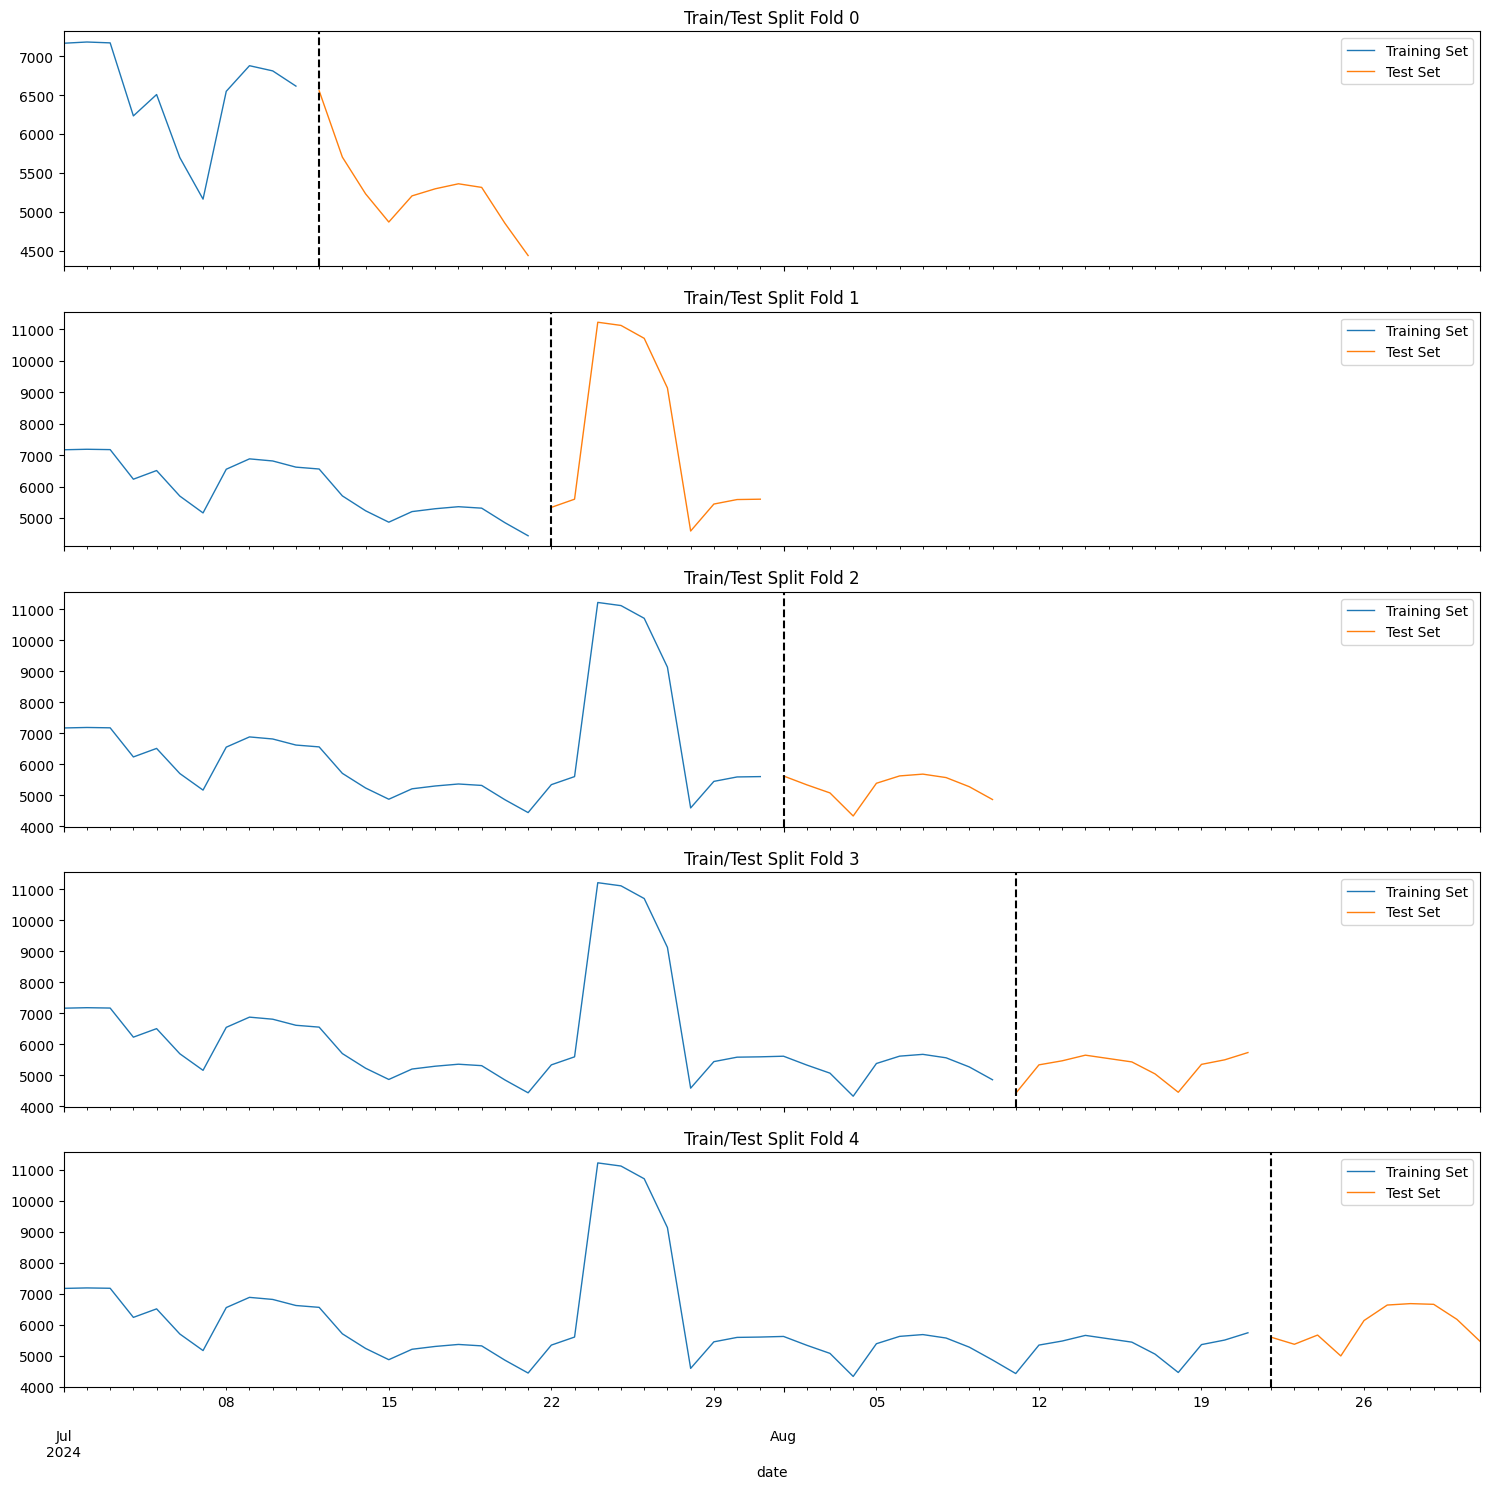

In [76]:
import matplotlib.pyplot as plt

# Set up subplots for each fold
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)  # Ensure number of subplots matches number of folds

fold = 0
for train_idx, val_idx in tscv.split(fc_clean):
    train = fc_clean.iloc[train_idx]
    test = fc_clean.iloc[val_idx]

    train['consumption'].plot(ax=axs[fold], lw=1,
                              label='Training Set',
                              title=f'Train/Test Split Fold {fold}')
    test['consumption'].plot(ax=axs[fold], lw=1,
                             label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    axs[fold].legend()  # Add legend for each subplot
    fold += 1

plt.tight_layout()
plt.show()

## Predicción del Futuro

Primero, se reentrena el modelo utilizando todos los datos disponibles. Esto permite aprovechar al máximo la información, ya que las predicciones se realizarán a partir de la última fecha registrada en el conjunto de datos:

In [77]:
#crear dataframe completo
fc_clean = create_attributes(fc_clean)

features = ['day','dayofweek','month','quarter','year','dayofyear']
target = ['consumption']

X_full = fc_clean[features]
y_full = fc_clean[target]

In [78]:

# Crear instancia del regresor con los mejores hiperparámetros del trial 32
xgb_regf = xgb.XGBRegressor(
    booster='gbtree',
    seed=42,
    n_estimators=343,  # Mejor valor para n_estimators
    early_stopping_rounds=50,
    objective='reg:squarederror',
    reg_lambda=1.6468,  # Mejor valor para reg_lambda
    max_depth=8,        # Mejor valor para max_depth
    learning_rate=0.1841,  # Mejor valor para learning_rate
    subsample=0.9188,      # Mejor valor para subsample
    colsample_bytree=0.8703,  # Mejor valor para colsample_bytree
    reg_alpha=0.000231,       # Mejor valor para reg_alpha
    min_child_weight=3,       # Mejor valor para min_child_weight
    gamma=0.2373              # Mejor valor para gamma
)

# Entrenar el modelo
xgb_regf.fit(
    X_full,
    y_full,
    eval_set=[(X_full, y_full)],
    verbose=100
)

# Predicción y evaluación
predictions = xgb_regf.predict(X_full)
mae = mean_absolute_error(y_full, predictions)
print(f"MAE después de ajustar el modelo: {mae:.2f}")

[0]	validation_0-rmse:1236.08345
[100]	validation_0-rmse:18.21589
[200]	validation_0-rmse:3.28521
[300]	validation_0-rmse:0.81316
[342]	validation_0-rmse:0.71778
MAE después de ajustar el modelo: 0.48


## Análisis de Resultados del Modelo de Regresión

### Evaluación de la métrica RMSE

1. **RMSE (Root Mean Square Error)**:
   - **[0] validation_0-rmse: 1236.08345**: Este valor inicial es bastante alto, lo que indica que el modelo al principio tiene un rendimiento muy pobre al predecir los datos de validación. Un RMSE elevado sugiere que hay una gran diferencia entre las predicciones y los valores reales.
   - **[100] validation_0-rmse: 18.21589**: Después de 100 iteraciones, el RMSE ha disminuido significativamente, lo que indica que el modelo está aprendiendo y mejorando su capacidad predictiva. Sin embargo, sigue siendo relativamente alto.
   - **[200] validation_0-rmse: 3.28521**: A las 200 iteraciones, el modelo muestra una mejora considerable. El RMSE ha bajado a un valor bastante bajo, indicando que las predicciones son mucho más precisas.
   - **[300] validation_0-rmse: 0.81316**: A medida que el modelo continúa entrenándose, el RMSE cae aún más, lo que sugiere que el modelo se está ajustando muy bien a los datos de entrenamiento.
   - **[342] validation_0-rmse: 0.71778**: Este es el RMSE más bajo registrado en este entrenamiento, indicando que el modelo tiene un buen desempeño en la predicción de los datos de validación.

### MAE (Mean Absolute Error)

- **MAE después de ajustar el modelo: 0.48**:
   - Un MAE de 0.48 es excelente, ya que sugiere que, en promedio, el modelo se desvía de las predicciones reales en menos de medio punto. Esto refuerza la idea de que el modelo se ajusta bien a los datos y que ha mejorado significativamente durante el entrenamiento.

### Conclusiones

1. **Mejora significativa**: La caída del RMSE de un valor inicial muy alto a un valor final de aproximadamente 0.71778 sugiere que el modelo ha aprendido de los datos de entrenamiento de manera efectiva. La mejora constante en el RMSE a lo largo de las iteraciones indica un buen ajuste y un modelo que es capaz de generalizar bien.

2. **Rendimiento sobresaliente**: El MAE final de 0.48 indica que el modelo tiene un rendimiento sobresaliente. Esto sugiere que las predicciones del modelo son muy precisas en relación con los valores reales, lo que es un indicador de éxito en tareas de regresión.

3. **Potencial de sobreajuste**: Dado que el RMSE y el MAE son muy bajos en comparación con los valores iniciales, sería útil monitorear el comportamiento del modelo en un conjunto de prueba separado para asegurarse de que no se ha sobreajustado a los datos de entrenamiento.

A continuación, se crea un nuevo dataframe que incluye las fechas a pronosticar. Posteriormente, este dataframe se concatena con el dataframe original, añadiendo una columna booleana para identificar las fechas correspondientes al futuro.

En este caso, se pronostican 4 meses hacia adelante. Para generar el rango de fechas en la frecuencia deseada, se utiliza el método `date_range` de Pandas, configurado para obtener fechas diarias:

In [79]:
#rango de septiembre a diciembre 2024
pred_dates = pd.date_range('2024-09-01','2024-12-31', freq='D')
preds_df = pd.DataFrame(index=pred_dates)

#Crear columna
preds_df['Future'] = True
fc_clean['Future'] = False

#Concatenar dataframes
pred_fc = pd.concat([fc_clean.loc[fc_clean.index >= '01-01-2018'], preds_df])

Se agregan atributos mediante la función `create_attributes` y, finalmente, se genera un dataframe con las fechas futuras para realizar el pronóstico. El dataframe "futuro" se usará como entrada del modelo, mientras que el dataframe "completo" permitirá visualizar la serie de tiempo final:

In [80]:
#agregar atributos
pred_fc = pred_fc.copy()
pred_fc = create_attributes(pred_fc)

#seleccionar fechas
future_pred_fc = pred_fc.query('Future').copy()
future_pred_fc.head()

,consumption,day,dayofweek,month,quarter,year,dayofyear,Future
2024-09-01,NaN,1,6,9,3,2024,245,True
2024-09-02,NaN,2,0,9,3,2024,246,True
2024-09-03,NaN,3,1,9,3,2024,247,True
2024-09-04,NaN,4,2,9,3,2024,248,True
2024-09-05,NaN,5,3,9,3,2024,249,True


# Pronóstico

Se asignan los valores pronosticados a una nueva columna llamada `prediction`, y finalmente, se genera una gráfica que muestra tanto los datos históricos como el pronóstico obtenido.

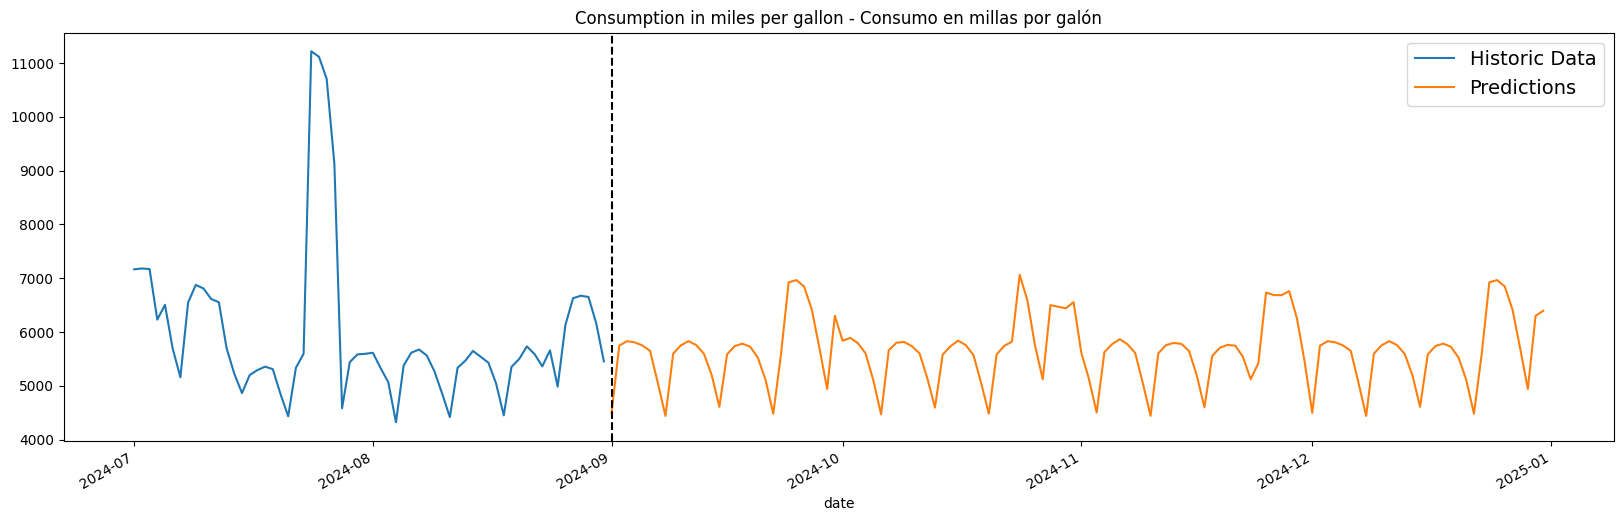

In [81]:
#predicciones del modelo
future_pred_fc['prediction'] = xgb_regf.predict(future_pred_fc[features])

#graficar
ax = fc_clean['consumption'].loc[fc_clean.index >= '01-01-2018']\
    .plot(figsize=(20, 6), lw=1.5, title='Consumption in miles per gallon - Consumo en millas por galón')
future_pred_fc['prediction'].plot(style='-', lw=1.5)
ax.axvline('2024-09-01', color='black', ls='--', lw=1.5)
plt.legend(['Historic Data','Predictions'], fontsize=14)
plt.show()